In [1]:
import collections
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import io

from sklearn import metrics
from tflite_runtime.interpreter import Interpreter
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm
import tarfile
import os

2022-12-31 01:46:29.551311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-31 01:46:30.004602: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-31 01:46:30.004648: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-31 01:46:31.685258: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

### download file

In [2]:
if not os.path.exists("SUN397.tar"):
    !wget http://vision.princeton.edu/projects/2010/SUN/SUN397.tar.gz
    !gunzip SUN397.tar.gz

### read images

In [3]:
def read_images(tar_filename, num_classes, num_images_per_class, rand_seed=0):
    # get filenames
    with tarfile.open(name=tar_filename, mode="r") as mytar:
        members = mytar.getmembers()
    filenames = [x.path for x in members]
    df = pd.DataFrame(data={"tarfile": members, "path": filenames})
    jpeg_df = df[df.path.str.endswith(".jpeg") | df.path.str.endswith(".jpg")].copy()
    jpeg_df["cls"] = jpeg_df.path.map(lambda x: "_".join(x.split("/")[2:-1]))
    
    # select classes
    np.random.seed(seed=rand_seed)
    selected_cls = np.random.permutation(jpeg_df.cls.unique())[:num_classes]
    
    # select images
    subdfs = []
    for cls in selected_cls:
        subdfs.append(jpeg_df[jpeg_df.cls == cls].sample(frac=1, random_state=rand_seed).iloc[:num_images_per_class])
    subdf = pd.concat(subdfs)
    
    # read images
    def load_img_from_tar(mytar, tarinfo):
        image = mytar.extractfile(tarinfo)
        image = image.read()
        image = Image.open(io.BytesIO(image))
        return image
    
    tqdm.tqdm.pandas()
    with tarfile.open(name=tar_filename, mode="r") as mytar:
        subdf["image"] = subdf.tarfile.progress_apply(lambda t: load_img_from_tar(mytar, t))
    
    return subdf

In [4]:
df = read_images("./SUN397.tar", 20, 100)

100%|████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1129.10it/s]


### calc features

In [5]:
def calc_features(df, model_path):
    interpreter = Interpreter(model_path=model_path)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.allocate_tensors()
    
    imgdata_series = df.image.progress_apply(lambda img: np.array(img.resize((224,224))))
    df["imgdata"] = imgdata_series.values
    
    df = df[df.imgdata.progress_apply(lambda x: len(x.shape)) >= 3].copy()
    
    def calc_feature(img):
        interpreter.set_tensor(input_details[0]['index'], [img.astype(np.float32) / 255])
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        return output_data

    df["features"] = df.imgdata.progress_apply(calc_feature)
    
    # conv to numpy array
    features = np.stack(df.features.to_numpy())
    features = features.reshape((features.shape[0], features.shape[2]))
    
    features_var = np.var(features, axis=0)
    features_std = np.sqrt(features_var)
    
    return df, features, features_std

In [6]:
df, features, features_std = calc_features(df, "../app/src/main/assets/lite-model_imagenet_mobilenet_v3_small_100_224_feature_vector_5_default_1.tflite")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
100%|█████████████████████████████████████████████████████████████████████| 1997/1997 [00:14<00:00, 133.49it/s]


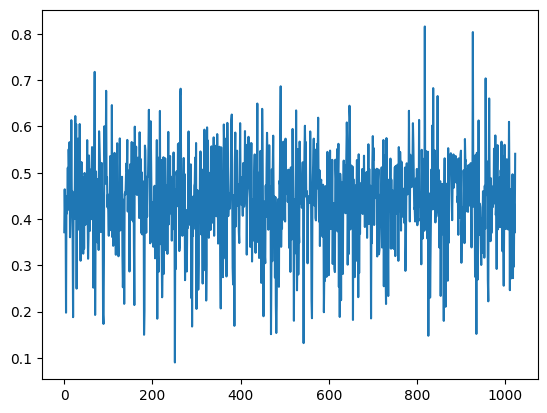

In [7]:
plt.plot(features_std)

In [8]:
def calc_score(f1, f2):
    dist = np.linalg.norm(((f1 - f2) / features_std))
    #dist = np.linalg.norm(((f1 - f2) ))
    return 1 / (dist + 0.000001)

def calc_roc(sample_index, df, calc_score_func):
    sample_features = df.loc[sample_index].features
    sample_category = df.loc[sample_index].cls
    
    list_label = []
    list_score = []
    for i, row in df.iterrows():
        if i == sample_index:
            continue
        list_label.append(
            1 if sample_category == row.cls else 0
        )
        
        list_score.append(
            calc_score_func(sample_features, row.features)
        )
    
    return list_label, list_score
    

In [18]:
def calc_roc_auc_mean(df, calc_score_func):
    roc_auc_list = []

    for i in tqdm.tqdm(df.sort_values("cls").index):
        list_label, list_score = calc_roc(i, df, calc_score_func)
        fpr, tpr, thresholds = metrics.roc_curve(list_label, list_score)
        roc_auc = metrics.auc(fpr, tpr)
        roc_auc_list.append(roc_auc)
    
    return np.mean(roc_auc_list)

## metho3: Apply weight according to feature value

### calc roc auc

In [12]:
subdf = df.iloc[::10]

In [14]:
subdf = calc_roc_list(subdf, calc_score_no_nomalize)

100%|████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 29.19it/s]
/tmp/ipykernel_234636/3544947224.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["roc_auc"] = roc_auc_list
/tmp/ipykernel_234636/3544947224.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pr_auc"] = pr_auc_list


## optimize

In [19]:
import optuna

def objective(trial):
    weight_min = trial.suggest_uniform('weight_min', 0, 2.0)
    weight_k= trial.suggest_uniform('weight_k', -10, 10)
    weight_type = trial.suggest_categorical('weight_type', ['linear', 'exp'])
    
    def calc_score(f1, f2):
        #dist = np.linalg.norm(((f1 - f2) / features_std))
        weight = np.maximum(f1, weight_min)
        if weight_type == "exp":
            weight = np.exp(weight * weight_k)
        dist = np.linalg.norm(((f1 - f2) * weight))
        return 1 / (dist + 0.000001)
    
    roc_auc_mean = calc_roc_auc_mean(subdf, calc_score)
    return roc_auc_mean

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-12-31 02:06:15,636] A new study created in memory with name: no-name-c8c0c8c3-513b-44b2-a920-ae6aa54cacce
/tmp/ipykernel_234636/2926514414.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_min = trial.suggest_uniform('weight_min', 0, 2.0)
/tmp/ipykernel_234636/2926514414.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_k= trial.suggest_uniform('weight_k', -10, 10)
100%|████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.06it/s]
[I 2022-12-31 02:06:22,777] Trial 0 finished with value: 0.8684254385964911 and parameters: {'weight_min': 1.2656162925736008, 'weight_k': 1.24842341562

In [23]:
trial = study.best_trial
 
print('  Value: {}'.format(trial.value))
 
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

  Value: 0.8906900584795321
  Params: 
    weight_min: 0.5991100567837596
    weight_k: -8.74439175797172
    weight_type: linear


<AxesSubplot: >

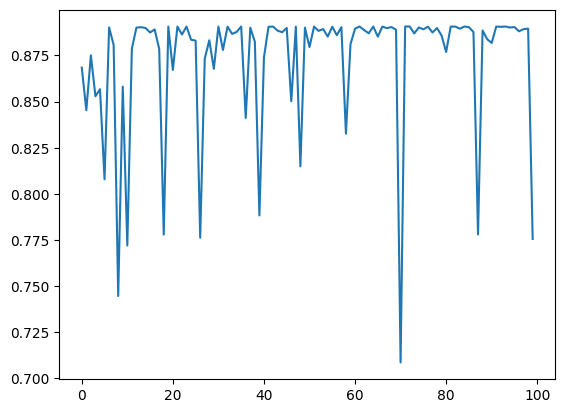

In [22]:
df_study = study.trials_dataframe()
df_study.value.plot()

### plot result

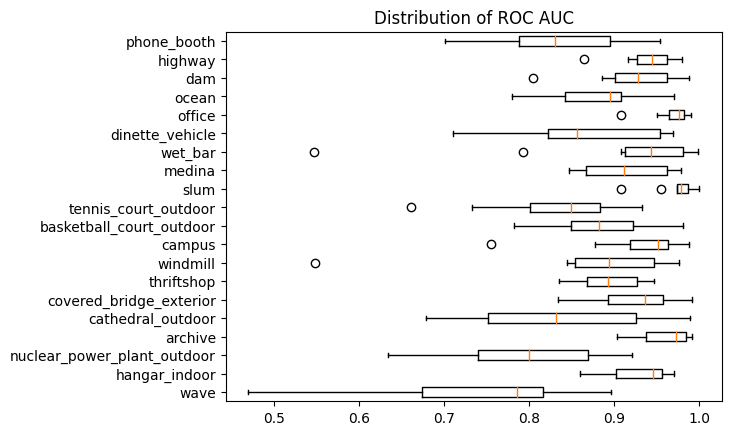

roc auc:  0.8901725146198831 0.9105263157894736 1.0 0.4695906432748538


In [16]:
plot_roc_auc(subdf)